# Import Libraries

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
!pip install xgboost
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report
!pip install shap
import shap


import warnings
warnings.filterwarnings('ignore')

# Load & Preprocess Data

In [44]:
# Load pipe-delimited file
df = pd.read_csv("../data/MachineLearningRating_v3.txt", delimiter='|')

# Convert numeric columns
df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')
df['CalculatedPremiumPerTerm'] = pd.to_numeric(df['CalculatedPremiumPerTerm'], errors='coerce')

# Create binary column for claim occurrence
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
# Convert TransactionMonth to datetime
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# Extract year and month as separate features
df['TransMonth'] = df['TransactionMonth'].dt.month
df['TransYear'] = df['TransactionMonth'].dt.year

# Drop original string datetime column
df.drop(columns=['TransactionMonth'], inplace=True)


# Handle Missing Data

In [45]:
# Drop irrelevant columns
df.drop(columns=['Country', 'Citizenship', 'Language', 'Title', 'VehicleIntroDate'], inplace=True)
df.dropna(subset=['TotalClaims', 'TotalPremium', 'CalculatedPremiumPerTerm'], inplace=True)

# Fill missing
df.fillna({
    'Gender': 'Unknown',
    'Province': 'Unknown',
    'PostalCode': df['PostalCode'].mode()[0],
}, inplace=True)

# Feature Encoding

In [46]:
# Use Label Encoding or One-Hot
# cat_cols = ['Gender', 'Province', 'MaritalStatus', 'make', 'VehicleType', 'AccountType']
# cat_cols = [col for col in cat_cols if col in df.columns]

# One-hot encode ALL object columns
object_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=object_cols, drop_first=True)

# Feature Engineering

In [47]:
# Age of vehicle
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'], errors='coerce')
df['VehicleAge'] = 2025 - df['RegistrationYear']

# Ratio: Premium / SumInsured
df['PremiumToSumRatio'] = df['CalculatedPremiumPerTerm'] / df['SumInsured']




# Model 1: Predicting Claim Severity

In [ ]:
from sklearn.impute import SimpleImputer
few_missing_cols = ['mmcode', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors']
imputer_few = SimpleImputer(strategy='median')
df[few_missing_cols] = imputer_few.fit_transform(df[few_missing_cols])

#Drop high-missing-value columns
df.drop(columns=['CustomValueEstimate', 'NumberOfVehiclesInFleet'], inplace=True)

# Feature Selection
X_all = df.drop(columns=['TotalClaims','HasClaim', 'PolicyID', 'CalculatedPremiumPerTerm'],errors='ignore')
y_all = df['TotalClaims']

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

rf_selector = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
rf_selector.fit(X_train_fs, y_train_fs)

importances = rf_selector.feature_importances_
top_50_indices = np.argsort(importances)[::-1][:50]
top_features = X_all.columns[top_50_indices]

X = df[top_features]
y = df['HasClaim']  # Binary target for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))
print("R²:", r2_score(y_test, pred_lr))


#Random Forest
rf = RandomForestRegressor(n_estimators=50,n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("R²:", r2_score(y_test, pred_rf))

#XGBoost
xgb = XGBRegressor(n_estimators=50, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, pred_xgb)))
print("R²:", r2_score(y_test, pred_xgb))



# SHAP Analysis

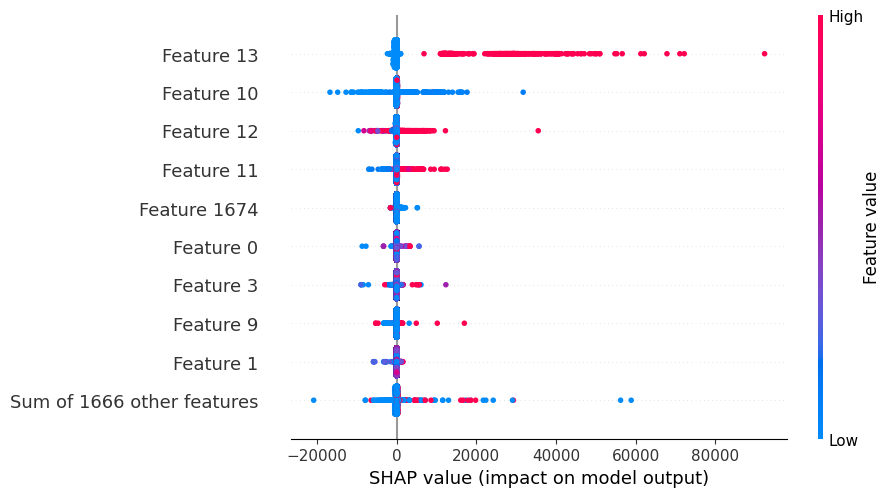

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=10)


# Model 2: Predicting Probability of Claim (Classification)

In [ ]:
X_cls = df[top_features]
y_cls = df['HasClaim']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_c, y_train_c)
preds = xgb_clf.predict(X_test_c)

print(classification_report(y_test, preds))


# Premium = Prob(Claim) * Pred(Severity) + Loading

In [ ]:
# Predict probability of claim
proba = xgb_clf.predict_proba(X_test_c)[:, 1]

# Use same top features for severity model
X_sev = df[top_features]
y_sev = df['TotalClaims']
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(X_sev, y_sev, test_size=0.2, random_state=42)

xgb_reg = XGBRegressor(n_estimators=50, n_jobs=-1, random_state=42)
xgb_reg.fit(X_train_sev, y_train_sev)
severity_pred = xgb_reg.predict(X_test_sev)

# Combine for premium
loading = 100  # constant business cost
profit_margin = 0.1

predicted_premium = proba * severity_pred + loading + profit_margin
